# Notebook 02: Agents in Grid World

Trong notebook này, chúng ta sẽ cài đặt và so sánh ba loại agent:
- Reflex agent (tác nhân phản xạ)
- Goal-based agent (tác nhân dựa trên mục tiêu)
- Utility-based agent (tác nhân dựa trên hàm hữu dụng)

Môi trường minh họa là **Grid World**.

In [184]:
import random
import matplotlib.pyplot as plt
import numpy as np

class GridWorld:
    def __init__(self, size=5, start=(0,0), goal=(4,4), obstacles=[]):
        self.size = size
        self.start = start
        self.goal = goal
        self.obstacles = obstacles
        self.reset()

    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos
        if action == 'UP':
            new_pos = (x-1, y)
        elif action == 'DOWN':
            new_pos = (x+1, y)
        elif action == 'LEFT':
            new_pos = (x, y-1)
        elif action == 'RIGHT':
            new_pos = (x, y+1)
        else:
            new_pos = self.agent_pos

        # Kiểm tra biên và chướng ngại vật
        if (0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size and new_pos not in self.obstacles):
            self.agent_pos = new_pos
        
        reward = -1
        done = False
        if self.agent_pos == self.goal:
            reward = 10
            done = True
        return self.agent_pos, reward, done

    def render(self, trajectory=None, agent_pos=None, show=True):
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_xticks(range(self.size))
        ax.set_yticks(range(self.size))
        ax.grid(True)
        ax.set_xlim(-0.5, self.size - 0.5)
        ax.set_ylim(-0.5, self.size - 0.5)
        ax.invert_yaxis()

        # Vẽ chướng ngại vật
        for (x,y) in self.obstacles:
            ax.text(y, x, "X", ha="center", va="center", fontsize=14, color="red")

        # Vẽ start & goal
        ax.text(self.start[1], self.start[0], "S", ha="center", va="center", fontsize=14, color="blue")
        ax.text(self.goal[1], self.goal[0], "G", ha="center", va="center", fontsize=14, color="green")

        # Vẽ quỹ đạo
        if trajectory is not None and len(trajectory) > 1:
            xs, ys = zip(*trajectory)
            ax.plot(ys, xs, marker="o", linestyle="--", alpha=0.7, color="orange")

        # Vẽ agent
        cur = agent_pos if agent_pos is not None else self.agent_pos
        ax.text(cur[1], cur[0], "A", ha="center", va="center", fontsize=14, color="purple")

        # Tiêu đề: số bước
        steps = (len(trajectory)-1) if trajectory else 0
        ax.set_title(f"Agent at {cur} | Steps: {steps}")

        if show:
            plt.show()
        else:
            return fig, ax



In [185]:
class ReflexAgent:
    def __init__(self, env):
        self.env = env

    def act(self):
        # Chọn hành động ngẫu nhiên nhưng tránh va chạm
        possible_actions = ['UP','DOWN','LEFT','RIGHT']
        random.shuffle(possible_actions)
        for action in possible_actions:
            x, y = self.env.agent_pos
            if action == 'UP': new_pos = (x-1, y)
            elif action == 'DOWN': new_pos = (x+1, y)
            elif action == 'LEFT': new_pos = (x, y-1)
            else: new_pos = (x, y+1)
            if (0 <= new_pos[0] < self.env.size and 0 <= new_pos[1] < self.env.size and new_pos not in self.env.obstacles):
                return action
        return 'UP'

In [186]:
class GoalBasedAgent:
    def __init__(self, env):
        self.env = env

    def act(self):
        # Di chuyển tham lam hướng về goal
        ax, ay = self.env.agent_pos
        gx, gy = self.env.goal
        if gx > ax:
            return 'DOWN'
        elif gx < ax:
            return 'UP'
        elif gy > ay:
            return 'RIGHT'
        elif gy < ay:
            return 'LEFT'
        else:
            return random.choice(['UP','DOWN','LEFT','RIGHT'])

In [187]:
class UtilityBasedAgent:
    def __init__(self, env):
        self.env = env

    def act(self):
        # Chọn hành động dựa trên hàm hữu dụng (khoảng cách Manhattan)
        actions = ['UP','DOWN','LEFT','RIGHT']
        best_action = None
        best_utility = -float('inf')
        for action in actions:
            x, y = self.env.agent_pos
            if action == 'UP': new_pos = (x-1, y)
            elif action == 'DOWN': new_pos = (x+1, y)
            elif action == 'LEFT': new_pos = (x, y-1)
            else: new_pos = (x, y+1)

            if (0 <= new_pos[0] < self.env.size and 0 <= new_pos[1] < self.env.size and new_pos not in self.env.obstacles):
                # Utility = - khoảng cách đến goal
                gx, gy = self.env.goal
                utility = - (abs(new_pos[0]-gx) + abs(new_pos[1]-gy))
                if utility > best_utility:
                    best_utility = utility
                    best_action = action
        return best_action if best_action else random.choice(actions)

In [188]:
import random

# Định nghĩa RandomAgent thật sự ngẫu nhiên
class RandomAgent:
    def __init__(self, env):
        self.env = env

    def act(self):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        return random.choice(possible_actions)



In [189]:
import random
import numpy as np

class LearningAgent:
    def __init__(self, env,
                 alpha=0.5, gamma=0.9,
                 epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9995,
                 episodes=20000, max_steps=50):
        self.env = env
        self.alpha = alpha                  # Learning rate
        self.gamma = gamma                  # Discount factor
        self.epsilon = epsilon              # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.episodes = episodes
        self.max_steps = max_steps          # giới hạn bước mỗi episode
        self.actions = ['UP','DOWN','LEFT','RIGHT']
        self.q_table = {}                   # {(state, action): value}

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        """Epsilon-greedy policy"""
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        qs = [self.get_q(state, a) for a in self.actions]
        return self.actions[np.argmax(qs)]

    def learn(self):
        """Huấn luyện nhiều episode"""
        for ep in range(self.episodes):
            self.env.reset()
            state = self.env.agent_pos
            done = False
            steps = 0

            while not done and steps < self.max_steps:
                action = self.choose_action(state)
                next_state, _, done = self.env.step(action)

                # 🎯 Reward shaping
                if next_state == self.env.goal:
                    reward = 100
                    done = True
                elif next_state in self.env.obstacles:
                    reward = -50
                    done = True
                else:
                    reward = -1

                # Q-learning update
                max_q_next = max([self.get_q(next_state, a) for a in self.actions])
                old_q = self.get_q(state, action)
                new_q = old_q + self.alpha * (reward + self.gamma * max_q_next - old_q)
                self.q_table[(state, action)] = new_q

                state = next_state
                steps += 1

            # Decay epsilon (khám phá ít dần)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            # Decay alpha nhẹ (tránh overfitting)
            self.alpha = max(0.01, self.alpha * 0.999)

    def act(self):
        """Chọn hành động greedy khi chạy thử nghiệm"""
        state = self.env.agent_pos
        qs = [self.get_q(state, a) for a in self.actions]
        return self.actions[np.argmax(qs)]


In [190]:
def run_episode(env, agent, max_steps=50):
    pos = env.reset()
    done = False
    trajectory = [pos]
    for _ in range(max_steps):
        action = agent.act()
        pos, reward, done = env.step(action)
        trajectory.append(pos)
        if done:
            break
    return trajectory


Running Reflex agent:
Trajectory: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 1), (6, 2), (5, 2), (4, 2), (3, 2), (4, 2), (4, 1), (4, 0), (4, 1), (4, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (5, 1), (5, 0), (6, 0), (6, 1), (5, 1), (4, 1), (5, 1), (5, 2), (5, 3), (6, 3), (5, 3), (5, 2), (5, 1), (5, 0), (5, 1), (6, 1), (5, 1), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 4), (5, 5), (4, 5), (3, 5)]


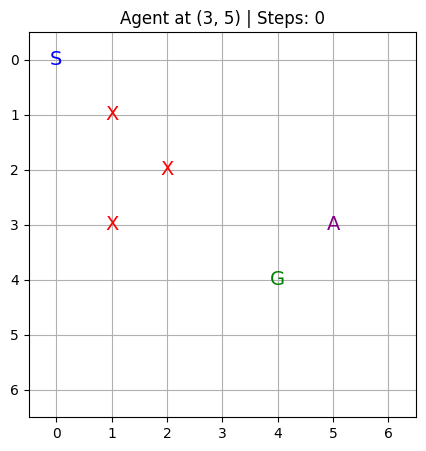


Running GoalBased agent:
Trajectory: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


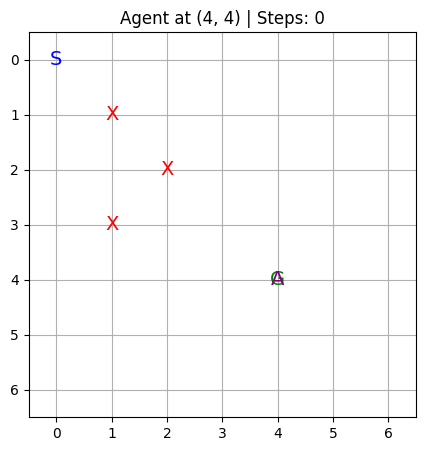


Running UtilityBased agent:
Trajectory: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


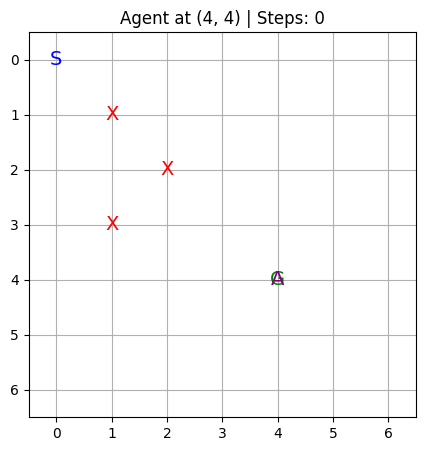


Running Random agent:
Trajectory: [(0, 0), (0, 0), (1, 0), (1, 0), (2, 0), (2, 0), (2, 1), (2, 0), (1, 0), (1, 0), (0, 0), (0, 1), (0, 1), (0, 2), (0, 1), (0, 0), (1, 0), (1, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 3), (2, 3), (1, 3), (2, 3), (2, 4), (1, 4), (0, 4), (0, 5), (1, 5), (0, 5), (0, 6)]


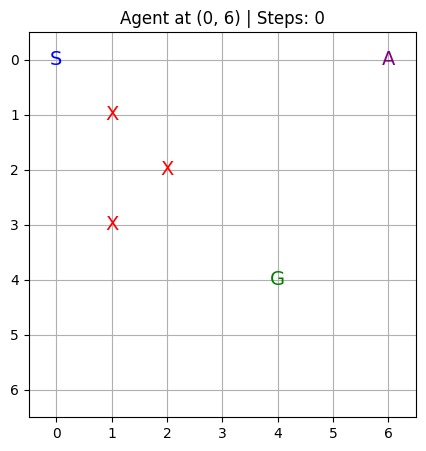


Running Learning agent:
Trajectory: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


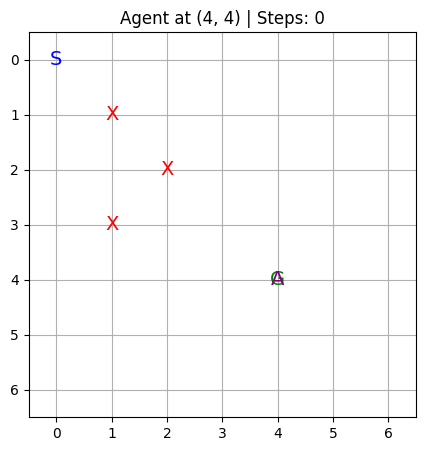


=== Evaluation Results ===
Reflex: Steps=51, Collisions=0, Revisits=31
GoalBased: Steps=9, Collisions=0, Revisits=0
UtilityBased: Steps=9, Collisions=0, Revisits=0
Random: Steps=51, Collisions=0, Revisits=36
Learning: Steps=9, Collisions=0, Revisits=0


In [191]:
# Khởi tạo environment
env = GridWorld(
    size=7, 
    start=(0,0), 
    goal=(4,4), 
    obstacles=[(1,1),(2,2),(3,1)]
)

# Tạo LearningAgent và huấn luyện trước
learning_agent = LearningAgent(env, episodes=5000)
learning_agent.learn()   # ✅ huấn luyện

# Thêm vào danh sách agent
agents = {
    'Reflex': ReflexAgent(env),
    'GoalBased': GoalBasedAgent(env),
    'UtilityBased': UtilityBasedAgent(env),
    'Random': RandomAgent(env),
    'Learning': learning_agent  # đã train
}

results = {}

# Chạy thử nghiệm cho từng agent
for name, agent in agents.items():
    print(f"\nRunning {name} agent:")
    traj = run_episode(env, agent)
    print("Trajectory:", traj)
    env.render()

    # --- Thống kê ---
    steps = len(traj)
    collisions = sum(1 for pos in traj if pos in env.obstacles)
    revisits = steps - len(set(traj))

    results[name] = {
        "steps": steps,
        "collisions": collisions,
        "revisits": revisits
    }

# In kết quả so sánh
print("\n=== Evaluation Results ===")
for name, stats in results.items():
    print(f"{name}: Steps={stats['steps']}, Collisions={stats['collisions']}, Revisits={stats['revisits']}")


In [192]:
from IPython.display import clear_output, display
import time

def animate_episode(env, agent, max_steps=50, delay=0.3):
    """Chạy và trực quan hóa đường đi của agent theo từng bước.
    - clear_output để cập nhật khung hình
    - env.render(show=False) để lấy fig/ax và hiển thị ngay trong cell
    """
    pos = env.reset()
    done = False
    steps = 0
    trajectory = [pos]
    while not done and steps < max_steps:
        action = agent.act()
        pos, reward, done = env.step(action)
        trajectory.append(pos)
        clear_output(wait=True)
        fig, ax = env.render(show=False)
        display(fig)
        plt.close(fig)
        time.sleep(delay)
        steps += 1
    return trajectory, steps, done


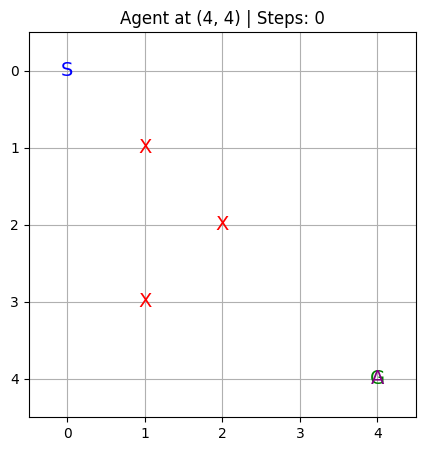

--- Kết quả agent Learning ---
Đã hoàn thành? True
Số bước đi: 8
Vị trí cuối: (4, 4)
Quỹ đạo: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]

=== Tất cả kết quả ===
Reflex: steps=36, done=True, last_pos=(4, 4)
GoalBased: steps=8, done=True, last_pos=(4, 4)
UtilityBased: steps=8, done=True, last_pos=(4, 4)
Random: steps=20, done=True, last_pos=(4, 4)
Learning: steps=8, done=True, last_pos=(4, 4)


In [193]:
# ====== Chạy animation và lưu kết quả cho từng agent ======
env = GridWorld(size=5, start=(0,0), goal=(4,4), obstacles=[(1,1),(2,2),(3,1)])
learning_agent = LearningAgent(env, episodes=5000)
learning_agent.learn()
agents = {
    'Reflex': ReflexAgent(env),
    'GoalBased': GoalBasedAgent(env),
    'UtilityBased': UtilityBasedAgent(env),
    'Random': RandomAgent(env),
    'Learning': learning_agent  # đã train
}

results = {}  # dictionary để lưu kết quả từng agent

for name, agent in agents.items():
    print(f"\n>>> Bắt đầu chạy agent: {name} (animation)...")
    
    traj, steps, done = animate_episode(env, agent, max_steps=60, delay=0.25)
    
    # Lưu kết quả
    results[name] = {
        'traj': traj,
        'steps': steps,
        'done': done,
        'last_pos': traj[-1]
    }
    
    # In kết quả ngay sau khi agent chạy xong
    print(f"--- Kết quả agent {name} ---")
    print(f"Đã hoàn thành? {done}")
    print(f"Số bước đi: {steps}")
    print(f"Vị trí cuối: {traj[-1]}")
    print(f"Quỹ đạo: {traj}")

# ✅ Sau vòng lặp, bạn vẫn có thể truy xuất kết quả của tất cả agent
print("\n=== Tất cả kết quả ===")
for name, res in results.items():
    print(f"{name}: steps={res['steps']}, done={res['done']}, last_pos={res['last_pos']}")


## 6. Thảo luận

### 6.1 Khả năng thích nghi khi môi trường thay đổi

| Tác tử           | Thích nghi khi môi trường thay đổi | Giải thích                                                                                                      |
|------------------|------------------------------------|----------------------------------------------------------------------------------------------------------------|
| **RandomAgent**      | Kém                               | Di chuyển ngẫu nhiên, không có chiến lược tổng thể. Khi lưới lớn hoặc nhiều vật cản, quỹ đạo dài, nhiều va chạm. |
| **ReflexAgent**      | Trung bình                       | Tránh va chạm cục bộ tốt, chỉ dựa vào thông tin xung quanh. Khi môi trường phức tạp, dễ đi vòng lặp, chưa tối ưu. |
| **GoalBasedAgent**   | Tốt                              | Luôn chọn đường đi ngắn nhất tới goal. Môi trường thay đổi ảnh hưởng ít, tác tử vẫn đến đích nhanh, không va chạm. |
| **UtilityBasedAgent**| Tốt                              | Chọn đường đi dựa trên giá trị utility, ổn định và ngắn. Một số trường hợp đặc biệt có thể bị kẹt.                |
| **LearningAgent**    | Rất tốt                          | Học từ kinh nghiệm, tối ưu hóa đường đi. Khi môi trường thay đổi, tác tử tự điều chỉnh chiến lược, dần thích nghi. |

**Kết luận:**
- Trong môi trường tĩnh, **GoalBasedAgent** và **UtilityBasedAgent** là hiệu quả nhất.
- Khi môi trường thay đổi, **LearningAgent** thích nghi tốt nhất nhờ khả năng học và tối ưu hóa dựa trên kinh nghiệm, giảm va chạm và bước đi thừa theo thời gian.

---

### 6.2 Ưu/nhược điểm trong thực tế

| Tác tử           | Ưu điểm                                                                 | Nhược điểm                                                                 |
|------------------|------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **RandomAgent**      | Đơn giản, không cần tính toán phức tạp                                 | Di chuyển ngẫu nhiên, tốn năng lượng, nhiều va chạm, không tối ưu           |
| **ReflexAgent**      | Tránh vật cản trực tiếp, dễ triển khai trên robot đơn giản             | Không có chiến lược tổng thể, dễ đi vòng lặp, quỹ đạo dài                   |
| **GoalBasedAgent**   | Luôn đi thẳng đến mục tiêu, ít bước thừa, không va chạm                | Cần biết trước vị trí goal, khó thích nghi nếu môi trường thay đổi          |
| **UtilityBasedAgent**| Tối ưu hóa đường đi dựa trên giá trị utility, ổn định                 | Có thể bị kẹt trong môi trường phức tạp, cần xác định utility chính xác     |
| **LearningAgent**    | Thích nghi với môi trường thay đổi, học được đường đi tối ưu           | Cần thời gian học, ban đầu có thể đi vòng lặp hoặc va chạm, phức tạp khi triển khai thực tế |

**Ví dụ thực tế:**
- **Robot hút bụi:** Nên dùng LearningAgent hoặc ReflexAgent vì môi trường nhà thay đổi, vật cản di động.
- **Xe tự lái:** Kết hợp GoalBasedAgent, UtilityBasedAgent và LearningAgent để đi đúng đường, tránh vật cản, học từ trải nghiệm thực tế.

## 📝 Bài tập cho sinh viên

1. **Thay đổi môi trường**
   - Thử tạo lưới có kích thước khác (ví dụ 7x7, 10x10).
   - Thêm/bớt chướng ngại vật và quan sát sự thay đổi trong quỹ đạo di chuyển.

2. **Điều chỉnh thuật toán tác tử**
   - Bổ sung thêm một tác tử **RandomAgent**: luôn chọn hành động ngẫu nhiên.
   - So sánh quỹ đạo và độ dài đường đi của RandomAgent với các tác tử khác.

3. **Đánh giá hiệu quả**
   - Tính tổng số bước mà mỗi tác tử đi từ start đến goal.
   - Ghi nhận số lần tác tử va phải chướng ngại vật hoặc quay lại ô cũ.

4. **Nâng cấp tác tử**
   - Thiết kế một **LearningAgent** đơn giản dùng Q-learning hoặc SARSA để học cách di chuyển đến goal.
   - So sánh hiệu quả của LearningAgent với UtilityBasedAgent.

5. **Quan sát trực quan**
   - Cập nhật hàm `render()` để hiển thị thêm:
     - Quỹ đạo các bước đi.
     - Số bước đã đi.
     - Ký hiệu khác biệt cho start (S), goal (G), chướng ngại vật (X), tác tử (A).
   - Vẽ đồ thị (sử dụng matplotlib) biểu diễn số bước cần thiết của mỗi tác tử.

6. **Thảo luận**
   - Khi môi trường thay đổi, tác tử nào thích nghi tốt nhất? Vì sao?
   - Ưu/nhược điểm của từng loại tác tử trong thực tế (ví dụ: robot hút bụi, xe tự lái).
